In [ ]:
import os
if os.getcwd().split("/")[-1] != 'BENDR-XAI': os.chdir("../")

import mne
import numpy as np
import matplotlib.pyplot as plt
from notebooks.utils import *

from matplotlib import animation
import matplotlib.cm as cm
import sys
from tqdm import tqdm

: 

In [ ]:
subjects_dir, subject, trans, src_path, bem_path = get_fsaverage()

: 

In [ ]:
# Generate a list with S001, S002, ..., S109
subjects = [f"S{i:03}" for i in range(1, 110)]

: 

In [ ]:
raw_open = get_raw(f'data/eegmmidb/files/{patient}/{patient}R01.edf', filter=True, resample=False, high_pass=8, low_pass=12)
annotation_open = get_annotations(f'data/eegmmidb/files/{patient}/{patient}R01.edf')
raw_open = get_window_dict(raw_open, annotation_open)['T0'][0]

: 

In [ ]:
raw_closed = get_raw(f'data/eegmmidb/files/{patient}/{patient}R02.edf', filter=True, resample=False, high_pass=8, low_pass=12)
annotation_closed = get_annotations(f'data/eegmmidb/files/{patient}/{patient}R02.edf')
raw_closed = get_window_dict(raw_closed, annotation_closed)['T0'][0]

: 

In [ ]:
random_edf_file_path = 'notebooks/S001R03.edf' 
mmidb_path = Path(r"/home/s194260/BENDR-XAI/data/eegmmidb/files")
parcellation_name = "aparc.a2009s"

info = get_raw(random_edf_file_path, filter=True).info # Just need one raw to get info
src = get_src(src_path)
fwd = get_fwd(info, trans, src_path, bem_path)

labels = get_labels(subjects_dir, parcellation_name = parcellation_name)

sfreq = int(raw_open.info['sfreq'])

vertices = get_vertices(src)
tris_vertices = get_vertices_tris(src)

sources = get_sources(src)
tris_sources = get_sources_tris(src)

: 

In [ ]:
raw_open.compute_psd().plot()
plt.show()

: 

In [ ]:
raw_closed.compute_psd().plot()
plt.show()

: 

In [ ]:
cov_open = get_cov(raw_open)
cov_closed = get_cov(raw_closed)
#compute_inverse = make_fast_inverse_operator(raw_open.info, fwd, cov, snr=snr)

: 

In [10]:
verbose = False
method = "eLORETA"
snr = 100
max_iter = 100
nave = 1
lambda2 = 1/snr**2
inv_open = mne.minimum_norm.make_inverse_operator(info, fwd, cov_open, verbose=verbose)
inv_open = mne.minimum_norm.prepare_inverse_operator(inv_open, nave, lambda2, method=method, method_params={'max_iter': max_iter}, verbose=verbose)

operator_open = make_fast_inverse_operator(info, fwd, cov_open, method="eLORETA", snr=100, nave=1, max_iter=1000, verbose=False)
operator_closed = make_fast_inverse_operator(info, fwd, cov_closed, method="eLORETA", snr=100, nave=1, max_iter=1000, verbose=False)

stc_open = operator_open(raw_open)
stc_closed = operator_closed(raw_closed)

In [38]:
visual_region_labels = [[label  for label in labels[hemi] if "occipital" in label.name] for hemi in range(2)]
frontal_region_labels = [[label  for label in labels[hemi] if "front" in label.name] for hemi in range(2)]

activity_open = get_power_per_label(stc_open, visual_region_labels, standardize=False)
activity_closed = get_power_per_label(stc_closed, visual_region_labels, standardize=False)

activity_open = np.concatenate(activity_open)
activity_closed = np.concatenate(activity_closed)

In [13]:
stc_open.plot()

Using pyvistaqt 3d backend.

Using control points [6.67762283e-10 7.71371099e-10 1.97394464e-09]


qt.qpa.plugin: Could not load the Qt platform plugin "wayland" in "" even though it was found.


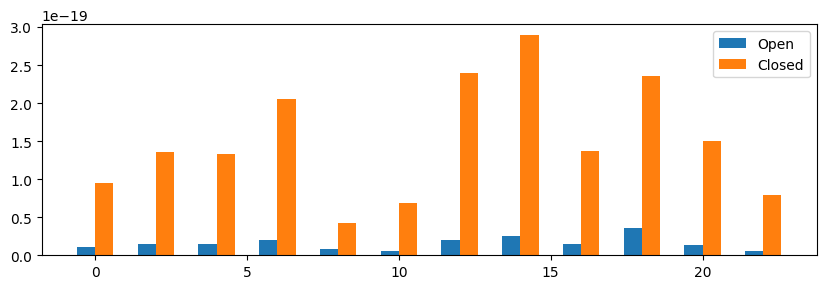

In [69]:
# Bar plot comparing activity_open and activity_closed
width = 0.6

fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(np.arange(len(activity_open))*2 - width/2, activity_open, label="Open", width=0.6)
ax.bar(np.arange(len(activity_closed))*2 + width/2, activity_closed, label="Closed", width=0.6)
ax.legend()
plt.show()

In [ ]:
color = np.mean(stc_closed.data, axis=1)
# Standardize color between 0 and 1
color = (color - np.min(color)) / (np.max(color) - np.min(color))
color = color.reshape(2, 10242)
#tris_values = vertex_values_to_tris_values(color, tris_sources, func=np.max)

In [68]:
activity_open = get_power_per_label(stc_open, labels, standardize=False)
values = activity_to_source_values(activity_open, labels, sources)
tris_values = vertex_values_to_tris_values(values, tris_sources, func=np.max)

In [69]:
activity = [[None]*len(labels[0]), [None]*len(labels[1])]

In [70]:
for hemi in range(2):
    for i, label in enumerate(labels[hemi]):
        if 'front' in label.name:
            activity[hemi][i] = 1
        else:
            activity[hemi][i] = 0

In [71]:
values = activity_to_source_values(activity, labels, sources)
tris_values = vertex_values_to_tris_values(values, tris_sources, func=np.max)

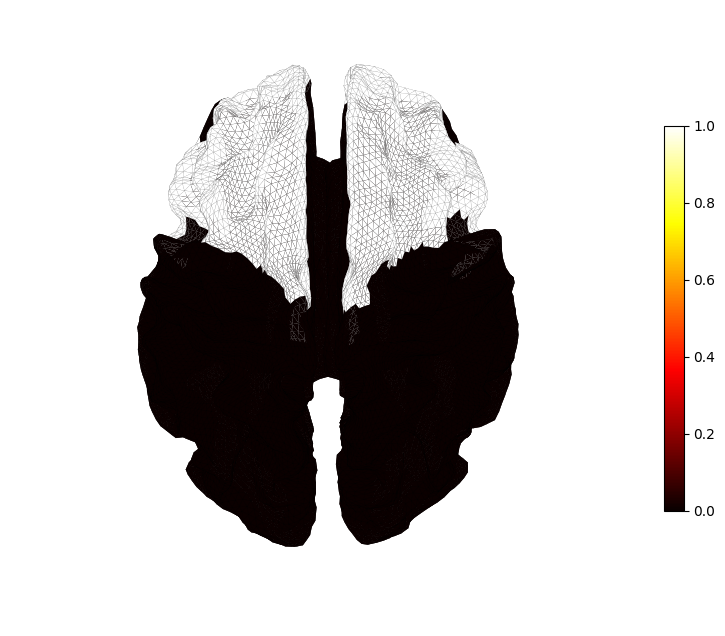

In [72]:
%matplotlib inline
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')

lh_mesh = ax.plot_trisurf(*sources[0].T, triangles=tris_sources[0], linewidth=0.1, shade=False,
                        antialiased=True, edgecolor=(0,0,0,0.5), cmap="hot")

lh_mesh.set_array(tris_values[0])
#fig.colorbar(lh_mesh, shrink=0.5)

rh_mesh = ax.plot_trisurf(*sources[1].T, triangles=tris_sources[1], linewidth=0.1, shade=False,
                        antialiased=True, edgecolor=(0,0,0,0.5), cmap="hot")

rh_mesh.set_array(tris_values[1])
fig.colorbar(rh_mesh, shrink=0.5)

ax.set_xlim(-0.06, 0.06)
ax.set_ylim(-0.08, 0.04)
ax.set_zlim(-0.04, 0.09)
ax.set_box_aspect([1,1,1])
ax.view_init(90, -90)
ax.axis("off")
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.tight_layout()
plt.show()